# **GR5242 HW04 Problem 5: Transfer learning with MobileNets**



**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

There are many examples of external links to documentation. If you see reference to a `pytorch` or similar object, try hovering over the word to see if documentation is linked.

## Description:
In this homework, you will practice (1) going over the full procedure of training a neural network and (2) extending your knowledge on TF2, by implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and to classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, you can refer to the official documentations for more info if necessary.



**Import modules for later usage.**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np


print("PyTorch version: ",torch.__version__)

PyTorch version:  2.5.0+cu121


In [2]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


## **Question 1: Download and format the data**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (1) Data Pre-processing

First, load the  dataset from Kaggle (https://www.kaggle.com/competitions/oxford-102-flower-pytorch/data) where you can click "Download All" for the flower data. You can also download it directly from the zip file provided.

Then you split the data into training and testing sets. How many training and testing samples do you have?

During the pre-processing stage, we would like to format all the images for the MobileNet module.

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [3]:
# Initialize some parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Define data transformations
transform = transforms.Compose([
    #do not restrain dim1 == dim2 == 224 here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #Custom transform to permute the dimensions
    #data is (3, dim1, dim2), we want (dim1, dim2, 3)
    #transforms.Lambda(lambda x: x.permute(1, 2, 0))
])

#Use validation set(contains labels) as a substitute for test,
#as test set under Kaggle is hidden for submission to compete for highest accuracy


# Assuming you have PyTorch datasets, replace root=' ' with your local directory.

########## Your code here ##########
from torchvision.datasets import Flowers102

# Load the dataset
#uses the built-in datase from torch, similar to that in tf
raw_train = Flowers102(root='', split="train", download=True)
raw_test = Flowers102(root='', split="test", download=True)

100%|██████████| 345M/345M [00:14<00:00, 24.2MB/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 362kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 10.1MB/s]


In [4]:
#-----------------------------------------------------------
# this part is not necessary
#for nn built-in flowers


#(note that the size of the dataset does match the tf dataset)

#raw_train
print(len(raw_train))
print(len(raw_test))

# Access a specific data point (e.g., the 10th data point)
index = 10  # Change this to the index you want to access
sample_image, label = raw_train[index]

# Display the label and other information
print("nn raw data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.size}")

# Apply the raw data transforms to raw_train and raw_test
train_nn = Flowers102(root='', split="train", download=True, transform=transform)
test_nn = Flowers102(root='', split="test", download=True, transform=transform)

#for nn build-in flowers: raw_train
print(len(train_nn))
print(len(test_nn))

sample_image, label = train_nn[100]
# Display the label and other information
print("nn standardized image data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.shape}")

1020
6149
nn raw data
Data at index 10:
Label: 1
Image shape: (500, 682)
1020
6149
nn standardized image data
Data at index 10:
Label: 10
Image shape: torch.Size([3, 224, 224])


### (2) Data Exploration

Let's plot some of the data.

In [6]:
# from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset # Import the Dataset class
assert isinstance(train_nn, Dataset)
assert isinstance(test_nn, Dataset)

# Print the datasets
print(train_nn)
print(test_nn)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: 
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 6149
    Root location: 
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


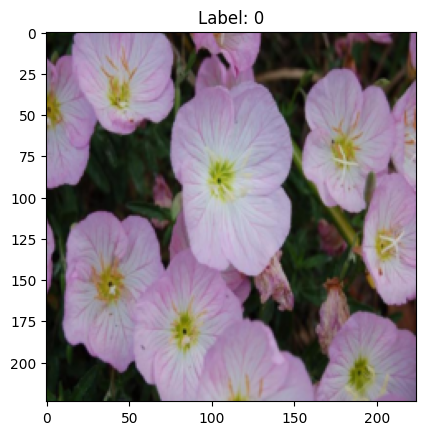

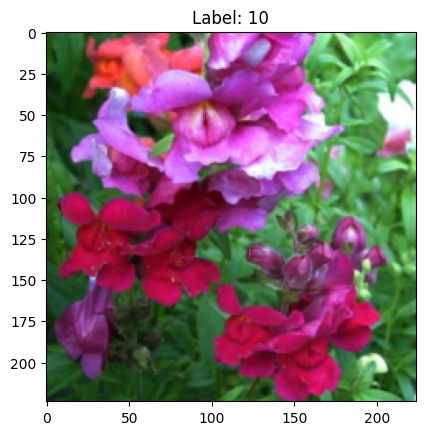

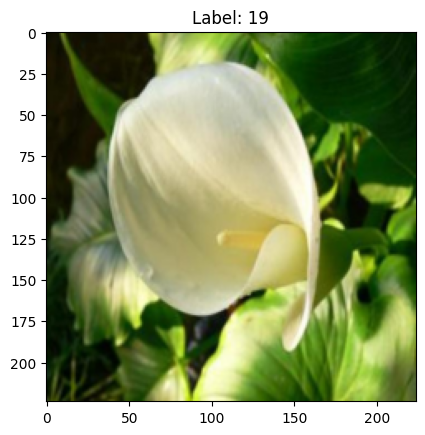

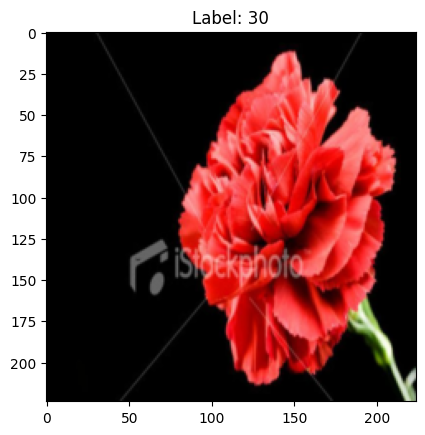

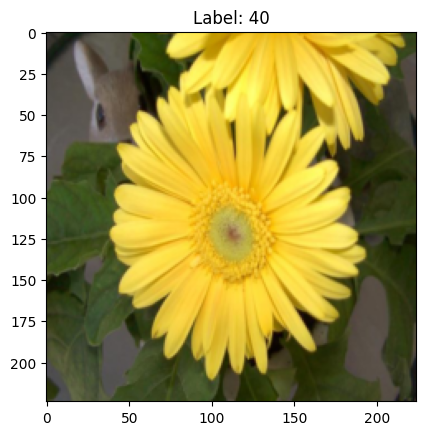

In [7]:
for i in range(5):  # Take example image 0,100,200,300,400
    index = i*100
    curr_f = train_nn[index][0]

    #reshape each data form (3, 224, 224) to (224, 224, 3) to plot img correctly
    reshaped_curr_f = curr_f.permute(1, 2, 0)

    curr_lab = train_nn[index][1]
    plt.title("Label: %d" % curr_lab)
    plt.imshow(reshaped_curr_f)
    plt.pause(0.5)

### **Reflection Question (1a):**
In the data exploration stage, what is the purpose of "***assert isinstance(train, Dataset)***"?


**Your Answer:**

Error Prevention: Ensures that train_nn is a dataset object with methods like __getitem__ and __len__, which are required by PyTorch’s DataLoader class. If train_nn isn’t a Dataset instance, attempting to use it in a DataLoader would cause errors.

## **Part 2: Self-defined CNN**

In this section, you will define your own CNN (convolutional neural network) to classify the Oxford flowers.

Recall from the first problem, to build a neural network using `torch`, we build a class that carries out the functions of the model, define an optimizer, and iterate through a few key steps.

Here, we can make use of [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to save us a little hassle, now that we have seen how to build from the ground up in problem 1.

### Instructions

One suggestion is that you build a model with the following architecture, although you are free to try others as well with the same idea:

1.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d) with `kernel_size` 2 and `stride` 2

2.) Repeat step 1 (or a couple times), being careful about input shape

3.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten)

4.) Fully connected layer using [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear) and [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU)

5.)[`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout)

6.) Linear layer returning us to number of classes (102)

7.) [`nothing`] or [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax) to get label likelihood. Remember now that depending on which of these you use, you will need either [`criterion = nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss) or [`criterion = nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss) in training. If you use `nn.CrossEntropyLoss()`, you will need the extra step of calling [`nn.functional.softmax(output, dim=1)`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax) to compare outputs to targets in model evaluation, but not before calculating the loss in your training loop.

After fitting the model, please test the accuracy of the prediction on the test set.

In this stage, we do not ask for a great performance (you should have 'some' predictive performance though). But please ensure that you obtain a trainable model with no programming bugs. You may find it helpful to print the training progress bar or epoch.

In [8]:
# Step 1: Model definition
# Use a nn.Sequential model for deining your own CNN

########## Your code here ##########
# Define the model using nn.Sequential, naming it model
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(128 * 28 * 28, 256),  # Adjust based on input size
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 102),
    nn.LogSoftmax(dim=1)
)






In [13]:
# Optional: print a summary of your model
# from torchsummary import summary

# Assuming your model_transfer is defined, you can print the summary
# summary(our_model, (3, 224, 224))  # Assuming input size is (3, 224, 224)

NameError: name 'our_model' is not defined

### Instructions:

Here we will prepare ourselves for training.

We need to define a few things before running our training loop, namely the `DataLoader`, `criterion`, [`optimizer`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), and [`lr_scheduler`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html).

In [14]:
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required
from torch.utils.data import DataLoader

# Assuming you have a PyTorch model named 'model'
train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)


# Define your loss function, naming it 'criterion'
########## Your code here ##########
criterion = nn.NLLLoss()


# Define your optimizer, 'optimizer' (Adam is suggested)
########## Your code here ##########
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.001)


# Learning rate scheduler, 'lr_scheduler' (StepLR is suggested)
########## Your code here ##########
from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.5)




### Instructions:

Fill in necessary blanks in the training loop, with the provided guidance

In [15]:
# Step 3: Model fitting
# Use the prepared training data to fit your CN
# Training loop
epochs = 15  # Set the number of training epochs
# Total number of data points in the dataset (number of points per epoch)
n_train = len(train_loader_nn.dataset)

print("start to train")
for epoch in range(epochs):
    #print("epoch " + str(epoch))
    model.train()
    total_accuracy = 0.0
    total_loss = 0.0

    for batch in train_loader_nn:
        inputs, labels = batch
        # zero the gradient, calculate outputs, calculate loss,
        # backpropagate, and take a step
        # this should be familiar from earlier problems in the assignment
        ########## YOUR CODE HERE ###########
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy for this batch
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().sum()
        total_accuracy += batch_accuracy.item()
        total_loss += loss.item() * len(labels)




        # Calculate accuracy for this batch
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().sum()
        total_accuracy += batch_accuracy.item()
        total_loss += loss.item() * len(labels)


    # Calculate the average accuracy for the entire epoch
    average_accuracy = total_accuracy / n_train
    average_loss = total_loss / n_train
    # Take a step in learning rate with 'lr_scheduler`
    ############# YOUR CODE HERE ############### Adjust learning rate
    lr_scheduler.step()

    print(f" Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.3f}, Accuracy: {average_accuracy * 100:.2f}%")
    #print("len train_loader is " + str(len(train_loader_nn)))


start to train
 Epoch 1/15, Loss: 9.320, Accuracy: 1.57%
 Epoch 2/15, Loss: 9.130, Accuracy: 3.73%
 Epoch 3/15, Loss: 8.805, Accuracy: 3.92%
 Epoch 4/15, Loss: 8.293, Accuracy: 10.00%
 Epoch 5/15, Loss: 7.726, Accuracy: 17.84%
 Epoch 6/15, Loss: 6.909, Accuracy: 30.59%
 Epoch 7/15, Loss: 6.278, Accuracy: 45.10%
 Epoch 8/15, Loss: 5.331, Accuracy: 65.88%
 Epoch 9/15, Loss: 4.433, Accuracy: 87.45%
 Epoch 10/15, Loss: 3.344, Accuracy: 111.96%
 Epoch 11/15, Loss: 2.339, Accuracy: 139.80%
 Epoch 12/15, Loss: 1.810, Accuracy: 150.78%
 Epoch 13/15, Loss: 1.291, Accuracy: 167.45%
 Epoch 14/15, Loss: 1.027, Accuracy: 171.37%
 Epoch 15/15, Loss: 0.818, Accuracy: 177.06%


In [16]:
# Step 4: Model evaluation
test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)
n_test = len(test_dataloader_nn.dataset)  # Total number of test data points

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation during evaluation
    test_total_accuracy = 0.0
    test_total_loss = 0.0

    # Iterate through the test dataset
    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch

        # Forward pass
        test_outputs = model(test_inputs)

        # Calculate the loss for the current batch
        test_loss = criterion(test_outputs, test_labels)

        # Accumulate the total loss (convert average loss to sum)
        test_total_loss += test_loss.item() * len(test_labels)

        # Calculate the accuracy for the current batch
        test_predicted_classes = test_outputs.argmax(dim=1)
        test_batch_accuracy = (test_predicted_classes == test_labels).float().sum()
        test_total_accuracy += test_batch_accuracy

    # Compute the average accuracy over the entire test set
    test_average_accuracy = test_total_accuracy / n_test

    # Compute the average loss over the entire test set
    test_average_loss = test_total_loss / n_test

    # Print results
    print(f"Test Loss: {test_average_loss:.4f}   Test Accuracy: {test_average_accuracy.item() * 100:.2f}%")


Test Loss: 4.4561   Test Accuracy: 16.85%


### **Reflection Questions 2a:**

(1) How did you choose your network structure? \\
    The exact network structure was selected to be simple and organ.articleFor the convolution layer, small filters of 3 x 3 were used in a series of layers that extract features of increasing complexity before it was followed by max pool layers to reduce dimensions. Such a setup ensures that the model targets specific pattern characteristics without much use of computational services. The latter is followed by fully connected layers that analyze the learned features, with the final output layer of 102 nodes for each type of flower. ReLU additions bring non-linearity into the model and dropout regularization reduces overfitting of the network and for this reason, the model is efficient and capable for image classification on this dataset\\.

    
(2) Which optimizer did you use? Why? \\
    The Adam optimizer was adopted due to its adaptive learning rate in which corrections depend on gradient moments for every parameter to be effective on compounding networks. Adam also converges faster than such optimizers as SCD, which makes it a good candidate for usage in deep networks, especially if the computational capabilities are slightly limited. Its stability and solidity causes it to be widely used in deep learning models, and requires little adjustment in helping with the training process.


**Your Answer:**






## **Part 3: Transfer Learning Using Pre-trained Model**

There are several types of transfer learning, as illustrated [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, you will practice B2, using MobileNet_V2.

### (1) Freeze the pre-trained model and fine-tune the transfer learning.

In [17]:
import torchvision

# Load the pre-trained MobileNetV2 model
MobileNetV2 = torchvision.models.mobilenet_v2(pretrained=True)
MobileNetV2.classifier = nn.Identity()  # Remove the classifier layers

# Set the model to evaluation mode
MobileNetV2.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 67.8MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Now you can go through the same steps to build and train the transfer learning model.

### Instructions:
Within the `model_transfer = nn.Sequential()` call, dd an Adaptive Average Pooling layer with [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d), then perform flattening and apply a linear layer as you should be familiar with from earlier.

As before, remember your choice of whether to use Cross Entropy or Negative Log Likelihood, and make sure to use the corresponding output of your model (i.e., whether to apply Softmax after calculating loss or within the model)

In [18]:
# Step 1: Model definition
# Use a torch.nn Sequential model for defining the transfer learning model (B1 style)

# Set MobileNetV2 parameters to non-trainable
for param in MobileNetV2.parameters():
    param.requires_grad = False

# Use a custom reshape layer
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1), 1, 1)

# Create a Sequential model in PyTorch
model_transfer = nn.Sequential(
    MobileNetV2,
    ReshapeLayer(),  # Reshape to [batch_size, num_channels, 1, 1]

########## Your code here ##########
  nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(1280, 102),  # Assuming MobileNetV2 has output of size 1280
    nn.LogSoftmax(dim=1)
)

In [19]:
# define batch size here
batch_size = 32
input_tensor = torch.randn([batch_size, 3, 224, 224])

# visualize the model graphical structure
#Iterate through the model and print the dimensions at each layer
for layer in model_transfer:
    input_tensor = layer(input_tensor)
    print(f"Layer: {layer.__class__.__name__}, Output Shape: {input_tensor.shape}")

Layer: MobileNetV2, Output Shape: torch.Size([32, 1280])
Layer: ReshapeLayer, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: AdaptiveAvgPool2d, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: Flatten, Output Shape: torch.Size([32, 1280])
Layer: Linear, Output Shape: torch.Size([32, 102])
Layer: LogSoftmax, Output Shape: torch.Size([32, 102])


In [21]:
#print(model_transfer)

### Instructions:

As before, write code to define your `optimizer`, `DataLoader`, `loss (criterion)`, and `lr_scheduler`.

Then, write a training loop.

Your code here should look similar to earlier in the assignment, outside of choosing hyperparameters, names, and possibly choice of loss.

In [22]:
# Step 2: Prepare for training
# Be sure to specify the optimizer, loss, DataLoader, lr_scheduler as before

########## Your code here ##########
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

train_loader_transfer = DataLoader(train_nn, batch_size=32, shuffle=True)
test_loader_transfer = DataLoader(test_nn, batch_size=32, shuffle=False)

# Loss function
criterion_transfer = nn.NLLLoss()

# Optimizer
optimizer_transfer = Adam(model_transfer.parameters(), lr=0.001)

# Learning rate scheduler
lr_scheduler_transfer = StepLR(optimizer_transfer, step_size=5, gamma=0.5)

# Training loop
epochs = 5

# Step 3: Model fitting
# Use the prepared training data to fit the transfer learning model

########## Your code here ##########
print("Starting training for the transfer learning model")
for epoch in range(epochs):
    model_transfer.train()  # Set model to training mode
    total_accuracy = 0.0
    total_loss = 0.0

    # Training loop
    for inputs, labels in train_loader_transfer:
        optimizer_transfer.zero_grad()  # Clear previous gradients
        outputs = model_transfer(inputs)  # Forward pass
        loss = criterion_transfer(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer_transfer.step()  # Update weights

        # Calculate accuracy for this batch
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().sum()
        total_accuracy += batch_accuracy.item()
        total_loss += loss.item() * len(labels)

    # Calculate the average accuracy and loss for the epoch
    average_accuracy = total_accuracy / len(train_loader_transfer.dataset)
    average_loss = total_loss / len(train_loader_transfer.dataset)

    # Adjust the learning rate
    lr_scheduler_transfer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.3f}, Accuracy: {average_accuracy * 100:.2f}%")

Starting training for the transfer learning model
Epoch 1/5, Loss: 4.300, Accuracy: 14.22%
Epoch 2/5, Loss: 2.245, Accuracy: 71.57%
Epoch 3/5, Loss: 1.207, Accuracy: 91.08%
Epoch 4/5, Loss: 0.767, Accuracy: 95.78%
Epoch 5/5, Loss: 0.493, Accuracy: 97.94%


In [23]:
# Step 3: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

#test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)

print("model_transfer")
model_transfer.eval()  # Set the model to evaluation mode
with torch.no_grad():

    test_total_accuracy = 0.0
    test_total_loss = 0.0  # Reset total loss at the beginning of each epoch

    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_outputs = model_transfer(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        # Accumulate the total loss (convert average loss to sum)
        test_total_loss += test_loss.item() * len(test_labels)
        _, test_predicted = torch.max(test_outputs, 1)  # Get the predicted class
        test_batch_accuracy = (test_predicted == test_labels).float().sum()
        test_total_accuracy += test_batch_accuracy.item()


    # Compute the average accuracy over the entire test set
    test_average_accuracy = test_total_accuracy / n_test

    # Compute the average loss over the entire test set
    test_average_loss = test_total_loss / n_test

    # Print results
    print(f"Test Loss: {test_average_loss:.3f}   Test Accuracy: {test_average_accuracy * 100:.2f}%")

model_transfer
Test Loss: 1.122   Test Accuracy: 80.97%


### (2) Fine-tune some parameters in your network to see if you can improve the performance on testing data. (Optional)

In [ ]:
########## Your code here ##########




### **Reflection Questions 3a:**

(1) Briefly explain the network structure of MobileNet and how is it different from other models? \
(2) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why? \
(3) What are some pros and cons of doing transfer learning? \
(4) What is a batch? How does the batch size affect the training process? \
(5) What is an epoch during the training process?

**Your Answer:**
## **1**
MobileNet employs relatively slim network architecture specifically for mobile & embedded applications. It trades traditional convolutions with depthwise separable convolutions, which are inclusive of depthwise convolution and pointwise convolution. This structure substantially decreases the number of parameters and computation compared with other structures and light amounts than most CNN structures, such as VGG or ResNet, that mainly use standard convection.

## **2**
The network is however very sensitive to the learning rate and the batch size. To sum up the learning rate defines how often the model updates and a value larger than this leads to divergence while taking a value smaller than this leads to slow convergence. The size of each batch influences the gradient; larger batch give well behaved gradients while small batch produce noised gradients which is not so good for model training.

##**3**
Pros: Transfer learning can easily use other models to train and do not requires large amount of data. It periodically results into enhanced performance particularly when information is scarce, by moving information from a bigger data set. Cons: There is also the problem of what has been called mismatch of initial features to the target task, which can restrict model capabilities. Fine-tuning also plays with hyperparameters and can add the further computational complexity.

##**3**
**Batch** is a set of samples processed in a single forward and backward operations throughout the test training data set. Batch size influences the training process from the memory perspective and time efficiency of gradient as well as the stability of the learning rate. Large batch sizes give stable gradients and are useful in making the training faster since more data are processed at once, but they take more space. A small batch size though consumes less memory contains noise which sometimes is beneficial for generalization but sometimes slows down the convergence.

## **5**
An epoch is therefore defined as the number of times each record in the training data set is used in estimation of the weights. For each epoch, the whole training examples set is presented to the model so that the model can judge each example based on other examples of the same data set. In practice, a single epoch takes several iterations in order to approach a minimum averaged over all weights by the amount of loss on the input data set.


(6) Describe any observation you find interesting from the above experiment (Open-ended).

**Your Answer:**

Interesting aspect that can be observed in this experiment is the influence of transfer learning on convergence rate and model performance. MobileNetV2 was effective in achieving reasonable estimate with shorter epochs and minimal training data compared to training a similar model from scratch. This provides great evidence of transfer learning in that less training time is required while better generalization is shown, even when the new learning is on a rather different data than the ImageNet used during pre-training.


